# Feature Representations

In [37]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.feature import local_binary_pattern

def extract_combined_features(image):
    # Extract all features
    color_features = extract_color_features(image)
    lbp_features = extract_lbp_features(image)
    hog_features = extract_hog_features(image)
    
    # Combine all features
    combined_features = np.concatenate([color_features, lbp_features, hog_features])
    
    return combined_features

def extract_color_features(img):
    # Convert to different color spaces
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Compute color histograms
    hist_rgb = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist_lab = cv2.calcHist([lab], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    # Flatten and normalize histograms
    hist_rgb = hist_rgb.flatten() / hist_rgb.sum()
    hist_hsv = hist_hsv.flatten() / hist_hsv.sum()
    hist_lab = hist_lab.flatten() / hist_lab.sum()
    
    # Compute mean and std for each channel
    means_rgb = img.mean(axis=(0, 1))
    stds_rgb = img.std(axis=(0, 1))
    
    return np.concatenate([hist_rgb, hist_hsv, hist_lab, means_rgb, stds_rgb])

def extract_lbp_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Set LBP parameters
    radius = 3  # Radius of the circle
    n_points = 8 * radius  # Number of points to consider in the LBP calculation
    
    # Compute the LBP representation of the image
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    
    # Compute the histogram of the LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Avoid division by zero
    
    return hist

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    return features

def extract_sift_features(image, num_features=100):
    sift = cv2.SIFT_create(nfeatures=num_features)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((num_features, 128))  # SIFT descriptor is 128-dimensional
    if descriptors.shape[0] < num_features:
        padding = np.zeros((num_features - descriptors.shape[0], 128))
        descriptors = np.vstack((descriptors, padding))
    return descriptors[:num_features].flatten()

def extract_surf_features(image, num_features=100, hessian_threshold=400):
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=hessian_threshold, nOctaves=4, nOctaveLayers=3, extended=False, upright=True)
    keypoints, descriptors = surf.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((num_features, 64))  # SURF descriptor is 64-dimensional
    if descriptors.shape[0] < num_features:
        padding = np.zeros((num_features - descriptors.shape[0], 64))
        descriptors = np.vstack((descriptors, padding))
    return descriptors[:num_features].flatten()

def extract_features(image, method):
    # Using the method prescribed in the paper: https://arxiv.org/pdf/1901.07828

    # HOG
    if method == 'HOG':
        return extract_hog_features(image)
    
    # SIFT
    if method == 'SIFT':
        return extract_sift_features(image)
        
    # SURF
    if method == 'SURF':
        return extract_surf_features(image)
    
    if method == 'Combined':
        return extract_combined_features(image)


def create_pixel_features(image, mask, method):
    X = extract_features(image, method)
    y = np.apply_along_axis(lambda x: x[0], 1, mask.reshape(-1,3))
    return X, y

Creating our training and testing sets

In [38]:
import os
from sklearn.model_selection import train_test_split

pathname = 'Dataset-small/data/WildScenes/WildScenes2d/V-01/'
sample_size = 10
target_size = (256, 256)

def resize_image_and_mask(image, mask, target_size):
    image_resized = cv2.resize(image, target_size)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return image_resized, mask_resized

X_all = []
y_all = []

image_filenames = [img_name for img_name in os.listdir(f'{pathname}image') if ':' not in img_name]
np.random.shuffle(image_filenames)
selected_filenames = image_filenames[:sample_size]

for img_name in selected_filenames:
    img = np.asarray(cv2.imread(f'{pathname}/image/{img_name}'))
    mask = np.asarray(cv2.imread(f'{pathname}/indexLabel/{img_name}'))
    img, mask = resize_image_and_mask(img, mask, target_size)
    img, mask = create_pixel_features(img, mask, method='Combined')
    X_all.append(img)
    y_all.append(mask)

X = np.array(X_all)
y = np.array(y_all)

def get_majority_values(arr):
    flat_arr = arr.flatten()
    
    # Get unique values and their counts
    unique, counts = np.unique(flat_arr, return_counts=True)
    
    # Find the maximum count
    max_count = counts.max()
    
    # Get all values with the maximum count
    majority_values = unique[counts == max_count]
    
    return majority_values.tolist()

majority_values = np.apply_along_axis(get_majority_values, 1, y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=majority_values, test_size=0.25, random_state=42)

In [39]:
def element_proportions(arr):
    flat_arr = arr.flatten()
    unique, counts = np.unique(flat_arr, return_counts=True)  
    total = len(flat_arr)
    proportions = counts / total    
    return dict(zip(unique, proportions))

print(element_proportions(y))
print(element_proportions(y_train))
print(element_proportions(y_test))

{2: 0.0922393798828125, 7: 0.09781951904296875, 8: 0.5267440795898437, 9: 0.00030517578125, 12: 0.0012847900390625, 15: 0.01088104248046875, 16: 0.00055694580078125, 17: 0.12303314208984376, 18: 0.14713592529296876}
{2: 0.08537074497767858, 7: 0.086029052734375, 8: 0.488861083984375, 9: 0.0004359654017857143, 12: 0.0018354143415178572, 15: 0.015544346400669642, 16: 0.0007956368582589286, 17: 0.14071219308035715, 18: 0.18041556222098215}
{2: 0.10826619466145833, 7: 0.12533060709635416, 8: 0.6151377360026041, 17: 0.08178202311197917, 18: 0.06948343912760417}


Fitting the model

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Gathering model predictions

In [41]:
y_pred = rf.predict(X_test)

Model evaluation using IOU

In [42]:
from sklearn.metrics import jaccard_score, accuracy_score

y_pred_whole = np.concatenate(y_pred)
y_test_whole = np.concatenate(y_test)
iou = jaccard_score(y_pred_whole, y_test_whole, average=None)
print(f'IoU for each class: {iou}')
print(f'Mean IoU: {np.mean(iou)}')
print(f'Accuracy: {accuracy_score(y_pred_whole, y_test_whole)}')

IoU for each class: [0.23030028 0.02776791 0.63747625 0.         0.12148616 0.2140048 ]
Mean IoU: 0.20517256894306676
Accuracy: 0.5994974772135416


In [43]:
img1 = np.asarray(cv2.imread('Dataset-small/data/WildScenes/WildScenes2d/V-01/image/1623379829-508641462.png'))
img1 = cv2.resize(img1, target_size)
features = extract_combined_features(img1)
y_pred1 = rf.predict([features])

img2 = np.asarray(cv2.imread('Dataset-small/data/WildScenes/WildScenes2d/V-01/image/1623379830-781623853.png'))
img2 = cv2.resize(img2, target_size)
features = extract_combined_features(img2)
y_pred2 = rf.predict([features])

In [44]:
print(y_pred1)
print(y_pred2)

[[ 8  8  8 ... 18 18 18]]
[[ 8  8  8 ... 18 18 18]]


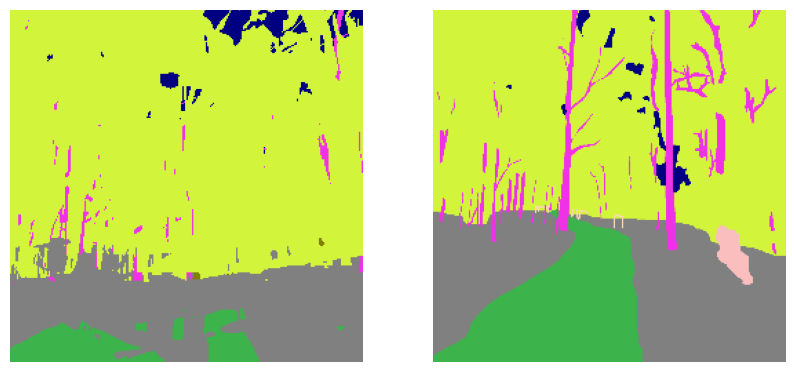

In [45]:
colours = [[0, 0, 0], 
           [75, 25, 230], 
           [75, 180, 60], 
           [25, 225, 255], 
           [200, 130, 0], 
           [180, 30, 145], 
           [240, 240, 70], 
           [230, 50, 240], 
           [60, 245, 210], 
           [75, 25, 230], 
           [128, 128, 0], 
           [40, 110, 170], 
           [200, 250, 255], 
           [0, 0, 128], 
           [195, 255, 170], 
           [0, 128, 128], 
           [190, 190, 250], 
           [128, 0, 0], 
           [128, 128, 128]]


y_pred1 = y_pred1.reshape(256,256)
y_pred2 = y_pred2.reshape(256,256)

result1 = np.array([[colours[num] for num in row] for row in y_pred1])
actual1 = np.asarray(cv2.imread('Dataset-small/data/WildScenes/WildScenes2d/V-01/label/1623379829-508641462.png'))
actual1 =  cv2.resize(actual1, target_size)

result2 = np.array([[colours[num] for num in row] for row in y_pred2])
actual2 = np.asarray(cv2.imread('Dataset-small/data/WildScenes/WildScenes2d/V-01/label/1623379830-781623853.png'))
actual2 =  cv2.resize(actual2, target_size)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(cv2.cvtColor(result1.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(cv2.cvtColor(actual1, cv2.COLOR_BGR2RGB))
plt.show()